In [1]:
import os.path as osp
n_eposides_tr=100 #训练集一个epoch生成多少个任务
n_eposides_va=100 # 测试集一个epoch生成多少个任务
img_size=30  #处理后的数据集图片大小
max_epoch=50
save_epoch=2
shot=1
query=3
train_way=5
test_way=5
save_path='./save_protonet'

# 数据集处理

In [2]:
import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import PIL.ImageOps 
import os

In [3]:
labels=[]
images=[]
for i in range(460):
    m=i+1
    samples_num=os.listdir(os.path.join('D:/数据库/palmdata/iitd',str(m)))
    for k in range(len(samples_num)):  #len(samples_num)
        j=k+1
        tpath=os.path.join(r'D:/数据库/palmdata/iitd',str(m),str(j)+'.jpeg')     #路径(/home/ouc/river/test)+图片名（img_m）
        fopen = Image.open(tpath)
        transform=transforms.Compose([transforms.Resize((img_size, img_size)),  # 将图片缩放到指定大小（h,w）或者保持长宽比并缩放最短的边到int大小
                                         transforms.Grayscale(),
                                         transforms.ToTensor()]) 
        data=np.array(transform(fopen))#data就是预处理后，可以送入模型进行训练的数据了
        images.append(data)
        labels.append(m)
        
labels=np.array(labels)
images=np.array(images)
#print(labels.shape)  #(2600,)
print(images.shape)   #(2600, 1, 28, 28)

classes, counts = np.unique(labels, return_counts=True)
#print(classes)  #[1~460]
#print(counts)  #每类各有多少个样本

#sum(counts[:360])  #前360类样本作为训练集=前2025个样本
#sum(counts[360:410]) #后50个类，278个样本作为验证集
#sum(counts[410:460]) #最后50个类，297个样本作为测试集

(2600, 1, 30, 30)


In [4]:
class PronetDataset(Dataset):
    def __init__(self,images,labels):
        self.imgs=images
        self.labs=labels  
        
    def __len__(self):
        return len(self.labs)

    def __getitem__(self, index):
        image, label = self.imgs[index], self.labs[index]
        return image, label

In [5]:
import torch
import numpy as np

class CategoriesSampler():
    def __init__(self, label, n_batch, n_cls, n_per):
        self.n_batch = n_batch
        self.n_cls = n_cls  #每个任务包含的样本类别数
        self.n_per = n_per  #每个任务每个类别包含的样本数=s+q
        label = np.array(label)  #数据集的列别标签
        self.m_ind = []  #按类别储存所有样本的索引
        self.classes, self.counts = np.unique(label, return_counts=True)
        #print(len(self.classes))  #360/5/5
        for i in self.classes:  #遍历数据集中的所有类
            ind = np.argwhere(label == i).reshape(-1)  #找出数据集中某个类别的样本索引
            ind = torch.from_numpy(ind)
            self.m_ind.append(ind)   #把每一个样本的索引按类别存放一起，后组成一个数组
        #print(self.m_ind)  #[[类别一的所有样本的索引]，[类别二,,,,,,,[]]   
    def __len__(self):
        return self.n_batch  #有多少个batch
    
    def __iter__(self):  
        for i_batch in range(self.n_batch):  #每次next(iter())生成一个任务数据，1个任务包含n_cls*（s+q）个样本,一个loader一共可以产生n_batch个任务
            batch = []
            classes = torch.randperm(len(self.m_ind))[:self.n_cls]  #从数据集中随机选择n_cls个类
            for c in classes:
                l = self.m_ind[c]  #被选出的某个类的所有样本索引
                pos = torch.randperm(len(l))[:self.n_per]  #从选出的每个类中随机取出n_per个样本
                batch.append(l[pos])  
            batch = torch.stack(batch).t().reshape(-1)  #batch保存一个任务所需的所有样本的索引，注意.t()是按（s+q）个存放
            #print(batch.shape)  #torch.Size([20])
            yield batch  #返回一个n way k shot任务需要的样本，即n*(s+q)

In [6]:
train_dir='D:/数据库/palmdata/iitd'
batch_size=32

#训练集
train_x=images[:2025]
train_y=labels[:2025]
trainset = PronetDataset(train_x,train_y)
train_sampler = CategoriesSampler(trainset.labs, n_eposides_tr,train_way, shot + query)
train_loader = DataLoader(dataset=trainset, batch_sampler=train_sampler,num_workers=0, pin_memory=True)

#验证集
val_x=images[2025:2303]
val_y=labels[2025:2303]
valset = PronetDataset(val_x,val_y)
val_sampler = CategoriesSampler(valset.labs, n_eposides_va,test_way, shot + query)
val_loader = DataLoader(dataset=valset, batch_sampler=val_sampler,num_workers=0, pin_memory=True)

#测试集
test_x=images[2303:2600]
test_y=labels[2303:2600]
testset = PronetDataset(test_x,test_y)
test_sampler = CategoriesSampler(testset.labs, n_eposides_va,test_way, shot + query)
test_loader = DataLoader(dataset=testset, batch_sampler=test_sampler,num_workers=0, pin_memory=True)

print(len(next(iter(train_loader))))  #2
print(next(iter(test_loader))[0].shape)  #torch.Size([20, 1, 30, 30])

2
torch.Size([20, 1, 30, 30])


# 可视化

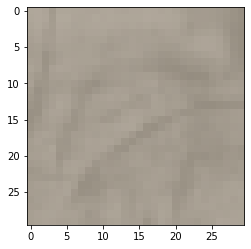

In [7]:
import matplotlib.pyplot as plt

def imshow(inp):
    inp=inp.numpy().transpose((1,2,0))
    mean=np.array([[0.485,0.456,0.406]])
    std=np.array([0.229,0.224,0.225])
    inp=std*inp+mean
    inp=np.clip(inp,0,1)
    plt.imshow(inp)

x,y=next(iter(val_loader))
imshow(x[0])

In [8]:
# a=0
# for i, batch in enumerate(train_loader, 1):
#     a=i
#     data, label = [_.cuda() for _ in batch]
#     p = shot * train_way  #每个任务的支持集样本数
#     data_shot, data_query = data[:p], data[p:]  #一个任务的支持集样本和查询集样本
#     label_shot, label_query = label[:p], label[p:]
#     #print(label)  #[16, 19, 59, 63, 20,,随机30个数，重复15遍]，所以前p个样本为支持集，后面的样本为查询集
#     #print(len(data_shot))  #30
#     #print(len(data)) #480
#     #print(data_query[0].shape)  #([3, 28, 28])
#     #print(len(label)) #450=30*15
    
# print(a) #10=n_batch


# 工具函数

In [9]:
import os
import shutil
import time
import pprint

import torch


class Averager():

    def __init__(self):
        self.n = 0
        self.v = 0

    def add(self, x):   #每次加入一个batch计算的loss，求平均值
        self.v = (self.v * self.n + x) / (self.n + 1)
        self.n += 1

    def item(self):
        return self.v


def count_acc(logits, label):
    pred = torch.argmax(logits, dim=1)
    return (pred == label).type(torch.cuda.FloatTensor).mean().item()


def dot_metric(a, b):
    return torch.mm(a, b.t())


def euclidean_metric(a, b):
    n = a.shape[0]
    m = b.shape[0]
    a = a.unsqueeze(1).expand(n, m, -1)
    b = b.unsqueeze(0).expand(n, m, -1)
    logits = -((a - b)**2).sum(dim=2)
    return logits


class Timer():

    def __init__(self):
        self.o = time.time()  #记录起始时间

    def measure(self, p=1): #返回训练模型花费的时间
        x = (time.time() - self.o) / p
        x = int(x)
        if x >= 3600:
            return '{:.1f}h'.format(x / 3600)
        if x >= 60:
            return '{}m'.format(round(x / 60))
        return '{}s'.format(x)

_utils_pp = pprint.PrettyPrinter()
def pprint(x):
    _utils_pp.pprint(x)


def l2_loss(pred, label):
    return ((pred - label)**2).sum() / len(pred) / 2



# 构造模型

In [10]:
# import torch.nn as nn


# def conv_block(in_channels, out_channels):
#     return nn.Sequential(
#         nn.ReflectionPad2d(1),   #padding
#         nn.Conv2d(in_channels, out_channels, kernel_size=3),
#         nn.ReLU(inplace=True),
#         nn.BatchNorm2d(out_channels),
#     )


# class Convnet(nn.Module):

#     def __init__(self, x_dim=1, hid_dim=4, z_dim=8):
#         super().__init__()
#         self.encoder = nn.Sequential(  
#             conv_block(x_dim, hid_dim),  
#             conv_block(hid_dim, z_dim),
#             conv_block(z_dim, z_dim), 
#         )
#         self.fc =  nn.Sequential( 
#             nn.Linear(8*100*100, 500),
#             nn.ReLU(inplace=True),

#             nn.Linear(500, 500),
#             nn.ReLU(inplace=True),

#             nn.Linear(500, 5)
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x=x.view(x.size()[0],-1)
#         return self.fc(x)   #拉直卷积运算后的特征shape为（？,1600)


In [11]:
import torch.nn as nn


def conv_block(in_channels, out_channels):
    bn = nn.BatchNorm2d(out_channels)
    nn.init.uniform_(bn.weight) # 随机初始化bn层的参数
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        bn,
        nn.ReLU(),
        nn.MaxPool2d(2)
    )


class Convnet(nn.Module):

    def __init__(self, x_dim=1, hid_dim=64, z_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(  #30=》15=》7=》3=》1
            conv_block(x_dim, hid_dim),  
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, z_dim),  
        )
        self.out_channels = 1600  #1600=5*5*64  经过卷积运算后拉直的结果

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)   #拉直卷积运算后的特征shape为（？,1*1*z_dim)


In [12]:
#实例化网络
model = Convnet().cuda()
    
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  #优化器
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)  #学习率调整器

print(model)

Convnet(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), str

# 训练模型

In [13]:
#把训练后的模型参数保存为args.save_path, name + '.pth'
    def save_model(name):
        torch.save(model.state_dict(), osp.join(save_path, name + '.pth'))

In [14]:
#记录训练每个batch的结果
trlog = {}
trlog['train_loss'] = []
trlog['val_loss'] = []
trlog['train_acc'] = []
trlog['val_acc'] = []
trlog['max_acc'] = 0.0  #记录模型最佳准确数

timer = Timer()  #用于计算训练模型花费的时间
                        #200+1
for epoch in range(1, max_epoch+1):   #训练模型迭代200轮
    lr_scheduler.step()  #初始化学习率调整器

    #模型训练
    model.train()

    tl = Averager()  #计算训练时在每个任务损失和准确数的均值
    ta = Averager()

    for i, batch in enumerate(train_loader, 1):  #此循环会进行n_batch次，每次产生一个任务所需的数据=(s+q)*cls
        data, _ = [_.cuda() for _ in batch]   
        #print(len(data))  #20
        #print(data[0].shape) #torch.Size([1, 30, 30])

        p = shot * train_way  #每个任务的支持集样本数
        data_shot, data_query = data[:p], data[p:]  #一个任务的支持集样本和查询集样本

        proto = model(data_shot)  #输出（支持集样本数=shot*train_way，64）
        #print(proto.shape)  #torch.Size([5, 64])
        proto = proto.reshape(shot, train_way, -1).mean(dim=0)  #计算支持集每类样本的样本均值作为该类的原型（train_way，64）

        label = torch.arange(train_way).repeat(query)  #（train_way，q）  初始化查询集每个样本的真实类别
        #print(label)  #tensor([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4])
        label = label.type(torch.cuda.LongTensor)

        logits = euclidean_metric(model(data_query), proto)  #计算查询集每个样本到支持集每个类别原型的欧式距离，（train_way*q,train_way*s）
        #print(logits.shape)  #torch.Size([15, 5])
        loss = F.cross_entropy(logits, label)  #计算交叉熵损失
        acc = count_acc(logits, label)  #计算预测准率,查询集图片对应logits最大的那个原型类别作为预测结果
        print('epoch {}, train {}/{}, loss={:.4f} acc={:.4f}'.format(epoch, i, len(train_loader), loss.item(), acc))

        #把一个任务的损失和准确数加入到tl和ta，用于计算在当前所有任务上的损失和准确数的均值
        tl.add(loss.item())
        ta.add(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        proto = None; logits = None; loss = None
    #print(i)

    #n_batch个episode上的平均损失和准确数
    tl = tl.item()
    ta = ta.item()

    #模型验证，每n_batch个任务（train_loader走完一遍）训练完后，验证一次模型
    model.eval()

    vl = Averager()
    va = Averager()
    
    for i, batch in enumerate(val_loader, 1):
        data, _ = [_.cuda() for _ in batch]
        p = shot * test_way
        data_shot, data_query = data[:p], data[p:]
        #with torch.no_grad():？？
        proto = model(data_shot)
        proto = proto.reshape(shot, test_way, -1).mean(dim=0)

        label = torch.arange(test_way).repeat(query)
        label = label.type(torch.cuda.LongTensor)
        
        logits = euclidean_metric(model(data_query), proto)
        loss = F.cross_entropy(logits, label)
#         print(label.shape)
#         print(logits.shape)
        acc = count_acc(logits, label)

        vl.add(loss.item())
        va.add(acc)
            
        proto = None; logits = None; loss = None

    vl = vl.item()
    va = va.item()
    print('epoch {}, val, loss={:.4f} acc={:.4f}'.format(epoch, vl, va))

    # 记录模型最佳
    if va > trlog['max_acc']:
        trlog['max_acc'] = va
        save_model('max-acc')  #保存获得最佳准确率的模型

    trlog['train_loss'].append(tl)
    trlog['train_acc'].append(ta)
    trlog['val_loss'].append(vl)
    trlog['val_acc'].append(va)

    torch.save(trlog, osp.join(save_path, 'trlog'))

    save_model('epoch-last')  #保存最终的训练模型

    if epoch % save_epoch == 0:  #每save_epoch个epoch保存一次模型
        save_model('epoch-{}'.format(epoch))

    print('ETA:{}/{}'.format(timer.measure(), timer.measure(epoch / max_epoch)))

epoch 1, train 1/100, loss=0.9929 acc=0.7333
epoch 1, train 2/100, loss=0.8276 acc=0.7333
epoch 1, train 3/100, loss=2.1648 acc=0.4000
epoch 1, train 4/100, loss=0.7735 acc=0.8667
epoch 1, train 5/100, loss=0.6558 acc=0.8000
epoch 1, train 6/100, loss=0.4450 acc=0.8000
epoch 1, train 7/100, loss=0.8178 acc=0.7333
epoch 1, train 8/100, loss=0.9438 acc=0.7333
epoch 1, train 9/100, loss=0.5033 acc=0.8000
epoch 1, train 10/100, loss=0.3115 acc=1.0000
epoch 1, train 11/100, loss=0.6770 acc=0.8667
epoch 1, train 12/100, loss=0.3565 acc=0.9333
epoch 1, train 13/100, loss=0.6661 acc=0.8000
epoch 1, train 14/100, loss=0.1049 acc=1.0000
epoch 1, train 15/100, loss=0.3031 acc=0.9333
epoch 1, train 16/100, loss=0.3051 acc=0.8667
epoch 1, train 17/100, loss=0.6371 acc=0.6667
epoch 1, train 18/100, loss=0.4828 acc=0.8667
epoch 1, train 19/100, loss=1.2371 acc=0.6000
epoch 1, train 20/100, loss=0.0897 acc=1.0000
epoch 1, train 21/100, loss=1.2164 acc=0.6000
epoch 1, train 22/100, loss=0.9282 acc=0.73

epoch 2, train 82/100, loss=0.5590 acc=0.8667
epoch 2, train 83/100, loss=0.0440 acc=1.0000
epoch 2, train 84/100, loss=0.0137 acc=1.0000
epoch 2, train 85/100, loss=0.6612 acc=0.8000
epoch 2, train 86/100, loss=0.0422 acc=1.0000
epoch 2, train 87/100, loss=0.0083 acc=1.0000
epoch 2, train 88/100, loss=0.1063 acc=1.0000
epoch 2, train 89/100, loss=0.0271 acc=1.0000
epoch 2, train 90/100, loss=0.0309 acc=1.0000
epoch 2, train 91/100, loss=0.2360 acc=0.9333
epoch 2, train 92/100, loss=0.1481 acc=0.9333
epoch 2, train 93/100, loss=0.2428 acc=0.8667
epoch 2, train 94/100, loss=0.4666 acc=0.8000
epoch 2, train 95/100, loss=0.0357 acc=1.0000
epoch 2, train 96/100, loss=0.0610 acc=1.0000
epoch 2, train 97/100, loss=0.0350 acc=1.0000
epoch 2, train 98/100, loss=0.0525 acc=1.0000
epoch 2, train 99/100, loss=0.2052 acc=0.8667
epoch 2, train 100/100, loss=0.0903 acc=0.9333
epoch 2, val, loss=0.2395 acc=0.9400
ETA:12s/5m
epoch 3, train 1/100, loss=0.1947 acc=0.9333
epoch 3, train 2/100, loss=0.534

epoch 4, train 61/100, loss=0.1443 acc=0.9333
epoch 4, train 62/100, loss=0.2130 acc=0.9333
epoch 4, train 63/100, loss=0.0375 acc=1.0000
epoch 4, train 64/100, loss=0.0235 acc=1.0000
epoch 4, train 65/100, loss=0.0205 acc=1.0000
epoch 4, train 66/100, loss=0.0213 acc=1.0000
epoch 4, train 67/100, loss=0.0284 acc=1.0000
epoch 4, train 68/100, loss=0.0553 acc=1.0000
epoch 4, train 69/100, loss=0.2112 acc=0.8667
epoch 4, train 70/100, loss=0.2240 acc=0.9333
epoch 4, train 71/100, loss=0.2300 acc=0.8667
epoch 4, train 72/100, loss=0.0155 acc=1.0000
epoch 4, train 73/100, loss=0.0485 acc=1.0000
epoch 4, train 74/100, loss=0.1020 acc=1.0000
epoch 4, train 75/100, loss=0.1655 acc=0.9333
epoch 4, train 76/100, loss=0.0606 acc=1.0000
epoch 4, train 77/100, loss=0.0667 acc=0.9333
epoch 4, train 78/100, loss=0.0362 acc=1.0000
epoch 4, train 79/100, loss=1.1414 acc=0.7333
epoch 4, train 80/100, loss=0.0236 acc=1.0000
epoch 4, train 81/100, loss=0.0093 acc=1.0000
epoch 4, train 82/100, loss=0.0947

epoch 6, train 42/100, loss=0.0292 acc=1.0000
epoch 6, train 43/100, loss=0.1324 acc=0.9333
epoch 6, train 44/100, loss=0.1584 acc=0.9333
epoch 6, train 45/100, loss=0.0135 acc=1.0000
epoch 6, train 46/100, loss=0.1647 acc=0.9333
epoch 6, train 47/100, loss=0.0171 acc=1.0000
epoch 6, train 48/100, loss=0.0164 acc=1.0000
epoch 6, train 49/100, loss=0.4176 acc=0.8000
epoch 6, train 50/100, loss=0.0034 acc=1.0000
epoch 6, train 51/100, loss=0.0794 acc=1.0000
epoch 6, train 52/100, loss=0.0096 acc=1.0000
epoch 6, train 53/100, loss=0.2068 acc=0.9333
epoch 6, train 54/100, loss=0.0679 acc=1.0000
epoch 6, train 55/100, loss=0.0210 acc=1.0000
epoch 6, train 56/100, loss=0.9225 acc=0.8667
epoch 6, train 57/100, loss=0.0057 acc=1.0000
epoch 6, train 58/100, loss=0.0131 acc=1.0000
epoch 6, train 59/100, loss=0.0255 acc=1.0000
epoch 6, train 60/100, loss=0.0109 acc=1.0000
epoch 6, train 61/100, loss=0.1027 acc=0.9333
epoch 6, train 62/100, loss=0.0017 acc=1.0000
epoch 6, train 63/100, loss=0.0084

epoch 8, train 19/100, loss=0.0848 acc=0.9333
epoch 8, train 20/100, loss=0.0103 acc=1.0000
epoch 8, train 21/100, loss=0.0258 acc=1.0000
epoch 8, train 22/100, loss=0.3886 acc=0.8667
epoch 8, train 23/100, loss=0.0802 acc=1.0000
epoch 8, train 24/100, loss=0.1257 acc=0.9333
epoch 8, train 25/100, loss=0.0012 acc=1.0000
epoch 8, train 26/100, loss=0.0011 acc=1.0000
epoch 8, train 27/100, loss=0.0026 acc=1.0000
epoch 8, train 28/100, loss=0.0180 acc=1.0000
epoch 8, train 29/100, loss=0.2073 acc=0.9333
epoch 8, train 30/100, loss=0.0067 acc=1.0000
epoch 8, train 31/100, loss=0.1431 acc=0.9333
epoch 8, train 32/100, loss=0.0259 acc=1.0000
epoch 8, train 33/100, loss=0.0091 acc=1.0000
epoch 8, train 34/100, loss=0.0433 acc=1.0000
epoch 8, train 35/100, loss=0.0611 acc=1.0000
epoch 8, train 36/100, loss=0.0136 acc=1.0000
epoch 8, train 37/100, loss=0.0129 acc=1.0000
epoch 8, train 38/100, loss=0.0027 acc=1.0000
epoch 8, train 39/100, loss=0.5309 acc=0.9333
epoch 8, train 40/100, loss=0.0346

epoch 9, train 96/100, loss=0.0222 acc=1.0000
epoch 9, train 97/100, loss=0.0347 acc=1.0000
epoch 9, train 98/100, loss=0.0217 acc=1.0000
epoch 9, train 99/100, loss=0.0208 acc=1.0000
epoch 9, train 100/100, loss=0.0120 acc=1.0000
epoch 9, val, loss=0.0809 acc=0.9720
ETA:46s/4m
epoch 10, train 1/100, loss=0.0026 acc=1.0000
epoch 10, train 2/100, loss=0.0005 acc=1.0000
epoch 10, train 3/100, loss=0.0928 acc=0.9333
epoch 10, train 4/100, loss=0.0345 acc=1.0000
epoch 10, train 5/100, loss=0.2174 acc=0.9333
epoch 10, train 6/100, loss=0.0159 acc=1.0000
epoch 10, train 7/100, loss=0.0479 acc=1.0000
epoch 10, train 8/100, loss=0.0660 acc=1.0000
epoch 10, train 9/100, loss=0.0043 acc=1.0000
epoch 10, train 10/100, loss=0.1726 acc=0.9333
epoch 10, train 11/100, loss=0.0008 acc=1.0000
epoch 10, train 12/100, loss=0.0343 acc=1.0000
epoch 10, train 13/100, loss=0.0401 acc=1.0000
epoch 10, train 14/100, loss=0.0714 acc=0.9333
epoch 10, train 15/100, loss=0.0016 acc=1.0000
epoch 10, train 16/100, l

epoch 11, train 71/100, loss=0.0497 acc=1.0000
epoch 11, train 72/100, loss=0.0029 acc=1.0000
epoch 11, train 73/100, loss=0.0029 acc=1.0000
epoch 11, train 74/100, loss=0.0841 acc=1.0000
epoch 11, train 75/100, loss=0.1651 acc=0.9333
epoch 11, train 76/100, loss=0.0049 acc=1.0000
epoch 11, train 77/100, loss=0.0039 acc=1.0000
epoch 11, train 78/100, loss=0.0003 acc=1.0000
epoch 11, train 79/100, loss=0.0632 acc=1.0000
epoch 11, train 80/100, loss=0.0009 acc=1.0000
epoch 11, train 81/100, loss=0.0307 acc=1.0000
epoch 11, train 82/100, loss=0.0017 acc=1.0000
epoch 11, train 83/100, loss=0.0694 acc=1.0000
epoch 11, train 84/100, loss=0.0263 acc=1.0000
epoch 11, train 85/100, loss=0.0109 acc=1.0000
epoch 11, train 86/100, loss=0.1554 acc=0.9333
epoch 11, train 87/100, loss=0.0287 acc=1.0000
epoch 11, train 88/100, loss=0.1284 acc=0.9333
epoch 11, train 89/100, loss=0.0056 acc=1.0000
epoch 11, train 90/100, loss=0.1300 acc=0.8667
epoch 11, train 91/100, loss=0.3751 acc=0.8000
epoch 11, tra

epoch 13, train 49/100, loss=0.0079 acc=1.0000
epoch 13, train 50/100, loss=0.0055 acc=1.0000
epoch 13, train 51/100, loss=0.0358 acc=1.0000
epoch 13, train 52/100, loss=0.0084 acc=1.0000
epoch 13, train 53/100, loss=0.0205 acc=1.0000
epoch 13, train 54/100, loss=0.0076 acc=1.0000
epoch 13, train 55/100, loss=0.0205 acc=1.0000
epoch 13, train 56/100, loss=0.0048 acc=1.0000
epoch 13, train 57/100, loss=0.0226 acc=1.0000
epoch 13, train 58/100, loss=0.0729 acc=0.9333
epoch 13, train 59/100, loss=0.0594 acc=1.0000
epoch 13, train 60/100, loss=0.0143 acc=1.0000
epoch 13, train 61/100, loss=0.0040 acc=1.0000
epoch 13, train 62/100, loss=0.1029 acc=0.9333
epoch 13, train 63/100, loss=0.0271 acc=1.0000
epoch 13, train 64/100, loss=0.0038 acc=1.0000
epoch 13, train 65/100, loss=0.0033 acc=1.0000
epoch 13, train 66/100, loss=0.0634 acc=0.9333
epoch 13, train 67/100, loss=0.0007 acc=1.0000
epoch 13, train 68/100, loss=0.0097 acc=1.0000
epoch 13, train 69/100, loss=0.0432 acc=1.0000
epoch 13, tra

epoch 15, train 24/100, loss=0.0003 acc=1.0000
epoch 15, train 25/100, loss=0.0370 acc=1.0000
epoch 15, train 26/100, loss=0.0000 acc=1.0000
epoch 15, train 27/100, loss=0.0042 acc=1.0000
epoch 15, train 28/100, loss=0.0132 acc=1.0000
epoch 15, train 29/100, loss=0.0011 acc=1.0000
epoch 15, train 30/100, loss=0.0048 acc=1.0000
epoch 15, train 31/100, loss=0.0280 acc=1.0000
epoch 15, train 32/100, loss=0.0240 acc=1.0000
epoch 15, train 33/100, loss=0.0013 acc=1.0000
epoch 15, train 34/100, loss=0.0069 acc=1.0000
epoch 15, train 35/100, loss=0.0005 acc=1.0000
epoch 15, train 36/100, loss=0.0000 acc=1.0000
epoch 15, train 37/100, loss=0.0045 acc=1.0000
epoch 15, train 38/100, loss=0.0016 acc=1.0000
epoch 15, train 39/100, loss=0.0943 acc=0.9333
epoch 15, train 40/100, loss=0.0028 acc=1.0000
epoch 15, train 41/100, loss=0.0010 acc=1.0000
epoch 15, train 42/100, loss=0.0892 acc=0.9333
epoch 15, train 43/100, loss=0.0145 acc=1.0000
epoch 15, train 44/100, loss=0.0221 acc=1.0000
epoch 15, tra

epoch 16, val, loss=0.1061 acc=0.9673
ETA:1m/4m
epoch 17, train 1/100, loss=0.0002 acc=1.0000
epoch 17, train 2/100, loss=0.0408 acc=1.0000
epoch 17, train 3/100, loss=0.0053 acc=1.0000
epoch 17, train 4/100, loss=0.0000 acc=1.0000
epoch 17, train 5/100, loss=0.0010 acc=1.0000
epoch 17, train 6/100, loss=0.0009 acc=1.0000
epoch 17, train 7/100, loss=0.0152 acc=1.0000
epoch 17, train 8/100, loss=0.0263 acc=1.0000
epoch 17, train 9/100, loss=0.0001 acc=1.0000
epoch 17, train 10/100, loss=0.0323 acc=1.0000
epoch 17, train 11/100, loss=0.0088 acc=1.0000
epoch 17, train 12/100, loss=0.0133 acc=1.0000
epoch 17, train 13/100, loss=0.0004 acc=1.0000
epoch 17, train 14/100, loss=0.0064 acc=1.0000
epoch 17, train 15/100, loss=0.0823 acc=1.0000
epoch 17, train 16/100, loss=0.0028 acc=1.0000
epoch 17, train 17/100, loss=0.1682 acc=0.9333
epoch 17, train 18/100, loss=0.0083 acc=1.0000
epoch 17, train 19/100, loss=0.0123 acc=1.0000
epoch 17, train 20/100, loss=0.0310 acc=1.0000
epoch 17, train 21/10

epoch 18, train 75/100, loss=0.0243 acc=1.0000
epoch 18, train 76/100, loss=0.0891 acc=0.9333
epoch 18, train 77/100, loss=0.2999 acc=0.8667
epoch 18, train 78/100, loss=0.0046 acc=1.0000
epoch 18, train 79/100, loss=0.0026 acc=1.0000
epoch 18, train 80/100, loss=0.1063 acc=0.9333
epoch 18, train 81/100, loss=0.0037 acc=1.0000
epoch 18, train 82/100, loss=0.0091 acc=1.0000
epoch 18, train 83/100, loss=0.0059 acc=1.0000
epoch 18, train 84/100, loss=0.0004 acc=1.0000
epoch 18, train 85/100, loss=0.0104 acc=1.0000
epoch 18, train 86/100, loss=0.0282 acc=1.0000
epoch 18, train 87/100, loss=0.0011 acc=1.0000
epoch 18, train 88/100, loss=0.0146 acc=1.0000
epoch 18, train 89/100, loss=0.0161 acc=1.0000
epoch 18, train 90/100, loss=0.0008 acc=1.0000
epoch 18, train 91/100, loss=0.0164 acc=1.0000
epoch 18, train 92/100, loss=0.0023 acc=1.0000
epoch 18, train 93/100, loss=0.0045 acc=1.0000
epoch 18, train 94/100, loss=0.0061 acc=1.0000
epoch 18, train 95/100, loss=0.0012 acc=1.0000
epoch 18, tra

epoch 20, train 51/100, loss=0.0852 acc=0.9333
epoch 20, train 52/100, loss=0.0001 acc=1.0000
epoch 20, train 53/100, loss=0.0002 acc=1.0000
epoch 20, train 54/100, loss=0.0013 acc=1.0000
epoch 20, train 55/100, loss=0.0004 acc=1.0000
epoch 20, train 56/100, loss=0.0834 acc=0.9333
epoch 20, train 57/100, loss=0.0162 acc=1.0000
epoch 20, train 58/100, loss=0.0013 acc=1.0000
epoch 20, train 59/100, loss=0.0195 acc=1.0000
epoch 20, train 60/100, loss=0.0016 acc=1.0000
epoch 20, train 61/100, loss=0.0046 acc=1.0000
epoch 20, train 62/100, loss=0.0499 acc=1.0000
epoch 20, train 63/100, loss=0.0002 acc=1.0000
epoch 20, train 64/100, loss=0.0020 acc=1.0000
epoch 20, train 65/100, loss=0.0098 acc=1.0000
epoch 20, train 66/100, loss=0.0054 acc=1.0000
epoch 20, train 67/100, loss=0.0277 acc=1.0000
epoch 20, train 68/100, loss=0.0270 acc=1.0000
epoch 20, train 69/100, loss=0.0015 acc=1.0000
epoch 20, train 70/100, loss=0.0134 acc=1.0000
epoch 20, train 71/100, loss=0.0116 acc=1.0000
epoch 20, tra

epoch 22, train 24/100, loss=0.0010 acc=1.0000
epoch 22, train 25/100, loss=0.0135 acc=1.0000
epoch 22, train 26/100, loss=0.0030 acc=1.0000
epoch 22, train 27/100, loss=0.0021 acc=1.0000
epoch 22, train 28/100, loss=0.0001 acc=1.0000
epoch 22, train 29/100, loss=0.0004 acc=1.0000
epoch 22, train 30/100, loss=0.0002 acc=1.0000
epoch 22, train 31/100, loss=0.0001 acc=1.0000
epoch 22, train 32/100, loss=0.0001 acc=1.0000
epoch 22, train 33/100, loss=0.0008 acc=1.0000
epoch 22, train 34/100, loss=0.0018 acc=1.0000
epoch 22, train 35/100, loss=0.0021 acc=1.0000
epoch 22, train 36/100, loss=0.0020 acc=1.0000
epoch 22, train 37/100, loss=0.0000 acc=1.0000
epoch 22, train 38/100, loss=0.0000 acc=1.0000
epoch 22, train 39/100, loss=0.0029 acc=1.0000
epoch 22, train 40/100, loss=0.0060 acc=1.0000
epoch 22, train 41/100, loss=0.0048 acc=1.0000
epoch 22, train 42/100, loss=0.0043 acc=1.0000
epoch 22, train 43/100, loss=0.0082 acc=1.0000
epoch 22, train 44/100, loss=0.0969 acc=1.0000
epoch 22, tra

epoch 23, val, loss=0.0499 acc=0.9813
ETA:2m/4m
epoch 24, train 1/100, loss=0.0004 acc=1.0000
epoch 24, train 2/100, loss=0.0021 acc=1.0000
epoch 24, train 3/100, loss=0.0002 acc=1.0000
epoch 24, train 4/100, loss=0.1317 acc=0.9333
epoch 24, train 5/100, loss=0.0015 acc=1.0000
epoch 24, train 6/100, loss=0.0000 acc=1.0000
epoch 24, train 7/100, loss=0.0089 acc=1.0000
epoch 24, train 8/100, loss=0.0231 acc=1.0000
epoch 24, train 9/100, loss=0.0041 acc=1.0000
epoch 24, train 10/100, loss=0.0009 acc=1.0000
epoch 24, train 11/100, loss=0.0002 acc=1.0000
epoch 24, train 12/100, loss=0.0031 acc=1.0000
epoch 24, train 13/100, loss=0.0004 acc=1.0000
epoch 24, train 14/100, loss=0.0000 acc=1.0000
epoch 24, train 15/100, loss=0.0008 acc=1.0000
epoch 24, train 16/100, loss=0.0120 acc=1.0000
epoch 24, train 17/100, loss=0.1366 acc=0.9333
epoch 24, train 18/100, loss=0.0035 acc=1.0000
epoch 24, train 19/100, loss=0.0089 acc=1.0000
epoch 24, train 20/100, loss=0.0057 acc=1.0000
epoch 24, train 21/10

epoch 25, train 79/100, loss=0.0109 acc=1.0000
epoch 25, train 80/100, loss=0.0306 acc=1.0000
epoch 25, train 81/100, loss=0.1042 acc=0.9333
epoch 25, train 82/100, loss=0.0612 acc=0.9333
epoch 25, train 83/100, loss=0.0007 acc=1.0000
epoch 25, train 84/100, loss=0.0036 acc=1.0000
epoch 25, train 85/100, loss=0.0010 acc=1.0000
epoch 25, train 86/100, loss=0.0005 acc=1.0000
epoch 25, train 87/100, loss=0.0008 acc=1.0000
epoch 25, train 88/100, loss=0.0252 acc=1.0000
epoch 25, train 89/100, loss=0.0011 acc=1.0000
epoch 25, train 90/100, loss=0.0001 acc=1.0000
epoch 25, train 91/100, loss=0.0000 acc=1.0000
epoch 25, train 92/100, loss=0.0161 acc=1.0000
epoch 25, train 93/100, loss=0.0005 acc=1.0000
epoch 25, train 94/100, loss=0.0034 acc=1.0000
epoch 25, train 95/100, loss=0.0008 acc=1.0000
epoch 25, train 96/100, loss=0.0023 acc=1.0000
epoch 25, train 97/100, loss=0.0001 acc=1.0000
epoch 25, train 98/100, loss=0.0017 acc=1.0000
epoch 25, train 99/100, loss=0.0008 acc=1.0000
epoch 25, tra

epoch 27, train 54/100, loss=0.0005 acc=1.0000
epoch 27, train 55/100, loss=0.0001 acc=1.0000
epoch 27, train 56/100, loss=0.0056 acc=1.0000
epoch 27, train 57/100, loss=0.0003 acc=1.0000
epoch 27, train 58/100, loss=0.0047 acc=1.0000
epoch 27, train 59/100, loss=0.0036 acc=1.0000
epoch 27, train 60/100, loss=0.0244 acc=1.0000
epoch 27, train 61/100, loss=0.0010 acc=1.0000
epoch 27, train 62/100, loss=0.0000 acc=1.0000
epoch 27, train 63/100, loss=0.0001 acc=1.0000
epoch 27, train 64/100, loss=0.0044 acc=1.0000
epoch 27, train 65/100, loss=0.0001 acc=1.0000
epoch 27, train 66/100, loss=0.3034 acc=0.9333
epoch 27, train 67/100, loss=0.0025 acc=1.0000
epoch 27, train 68/100, loss=0.0001 acc=1.0000
epoch 27, train 69/100, loss=0.0281 acc=1.0000
epoch 27, train 70/100, loss=0.0004 acc=1.0000
epoch 27, train 71/100, loss=0.0111 acc=1.0000
epoch 27, train 72/100, loss=0.0572 acc=0.9333
epoch 27, train 73/100, loss=0.0057 acc=1.0000
epoch 27, train 74/100, loss=0.0029 acc=1.0000
epoch 27, tra

epoch 29, train 28/100, loss=0.0000 acc=1.0000
epoch 29, train 29/100, loss=0.0001 acc=1.0000
epoch 29, train 30/100, loss=0.0003 acc=1.0000
epoch 29, train 31/100, loss=0.0357 acc=1.0000
epoch 29, train 32/100, loss=0.0013 acc=1.0000
epoch 29, train 33/100, loss=0.0507 acc=1.0000
epoch 29, train 34/100, loss=0.0006 acc=1.0000
epoch 29, train 35/100, loss=0.0001 acc=1.0000
epoch 29, train 36/100, loss=0.0001 acc=1.0000
epoch 29, train 37/100, loss=0.0001 acc=1.0000
epoch 29, train 38/100, loss=0.0003 acc=1.0000
epoch 29, train 39/100, loss=0.0000 acc=1.0000
epoch 29, train 40/100, loss=0.0001 acc=1.0000
epoch 29, train 41/100, loss=0.0000 acc=1.0000
epoch 29, train 42/100, loss=0.0001 acc=1.0000
epoch 29, train 43/100, loss=0.0267 acc=1.0000
epoch 29, train 44/100, loss=0.0000 acc=1.0000
epoch 29, train 45/100, loss=0.0264 acc=1.0000
epoch 29, train 46/100, loss=0.0001 acc=1.0000
epoch 29, train 47/100, loss=0.0039 acc=1.0000
epoch 29, train 48/100, loss=0.0016 acc=1.0000
epoch 29, tra

epoch 31, train 6/100, loss=0.0608 acc=0.9333
epoch 31, train 7/100, loss=0.0000 acc=1.0000
epoch 31, train 8/100, loss=0.0003 acc=1.0000
epoch 31, train 9/100, loss=0.0023 acc=1.0000
epoch 31, train 10/100, loss=0.0006 acc=1.0000
epoch 31, train 11/100, loss=0.0057 acc=1.0000
epoch 31, train 12/100, loss=0.0005 acc=1.0000
epoch 31, train 13/100, loss=0.0000 acc=1.0000
epoch 31, train 14/100, loss=0.0048 acc=1.0000
epoch 31, train 15/100, loss=0.0000 acc=1.0000
epoch 31, train 16/100, loss=0.0004 acc=1.0000
epoch 31, train 17/100, loss=0.0000 acc=1.0000
epoch 31, train 18/100, loss=0.0000 acc=1.0000
epoch 31, train 19/100, loss=0.0134 acc=1.0000
epoch 31, train 20/100, loss=0.0067 acc=1.0000
epoch 31, train 21/100, loss=0.0105 acc=1.0000
epoch 31, train 22/100, loss=0.0053 acc=1.0000
epoch 31, train 23/100, loss=0.0131 acc=1.0000
epoch 31, train 24/100, loss=0.0000 acc=1.0000
epoch 31, train 25/100, loss=0.0033 acc=1.0000
epoch 31, train 26/100, loss=0.0002 acc=1.0000
epoch 31, train 2

epoch 32, train 83/100, loss=0.0003 acc=1.0000
epoch 32, train 84/100, loss=0.0001 acc=1.0000
epoch 32, train 85/100, loss=0.0000 acc=1.0000
epoch 32, train 86/100, loss=0.0006 acc=1.0000
epoch 32, train 87/100, loss=0.0000 acc=1.0000
epoch 32, train 88/100, loss=0.0003 acc=1.0000
epoch 32, train 89/100, loss=0.0018 acc=1.0000
epoch 32, train 90/100, loss=0.0001 acc=1.0000
epoch 32, train 91/100, loss=0.0001 acc=1.0000
epoch 32, train 92/100, loss=0.0006 acc=1.0000
epoch 32, train 93/100, loss=0.0016 acc=1.0000
epoch 32, train 94/100, loss=0.0010 acc=1.0000
epoch 32, train 95/100, loss=0.0030 acc=1.0000
epoch 32, train 96/100, loss=0.0007 acc=1.0000
epoch 32, train 97/100, loss=0.0001 acc=1.0000
epoch 32, train 98/100, loss=0.0003 acc=1.0000
epoch 32, train 99/100, loss=0.0000 acc=1.0000
epoch 32, train 100/100, loss=0.0001 acc=1.0000
epoch 32, val, loss=0.0883 acc=0.9753
ETA:2m/4m
epoch 33, train 1/100, loss=0.0036 acc=1.0000
epoch 33, train 2/100, loss=0.0000 acc=1.0000
epoch 33, tra

epoch 34, train 60/100, loss=0.0001 acc=1.0000
epoch 34, train 61/100, loss=0.0000 acc=1.0000
epoch 34, train 62/100, loss=0.0044 acc=1.0000
epoch 34, train 63/100, loss=0.4835 acc=0.8000
epoch 34, train 64/100, loss=0.0000 acc=1.0000
epoch 34, train 65/100, loss=0.0006 acc=1.0000
epoch 34, train 66/100, loss=0.0022 acc=1.0000
epoch 34, train 67/100, loss=0.0211 acc=1.0000
epoch 34, train 68/100, loss=0.0004 acc=1.0000
epoch 34, train 69/100, loss=0.0258 acc=1.0000
epoch 34, train 70/100, loss=0.0001 acc=1.0000
epoch 34, train 71/100, loss=0.0022 acc=1.0000
epoch 34, train 72/100, loss=0.0000 acc=1.0000
epoch 34, train 73/100, loss=0.0002 acc=1.0000
epoch 34, train 74/100, loss=0.0028 acc=1.0000
epoch 34, train 75/100, loss=0.0000 acc=1.0000
epoch 34, train 76/100, loss=0.0832 acc=0.9333
epoch 34, train 77/100, loss=0.0001 acc=1.0000
epoch 34, train 78/100, loss=0.0002 acc=1.0000
epoch 34, train 79/100, loss=0.0000 acc=1.0000
epoch 34, train 80/100, loss=0.0006 acc=1.0000
epoch 34, tra

epoch 36, train 33/100, loss=0.0053 acc=1.0000
epoch 36, train 34/100, loss=0.0001 acc=1.0000
epoch 36, train 35/100, loss=0.0000 acc=1.0000
epoch 36, train 36/100, loss=0.0450 acc=1.0000
epoch 36, train 37/100, loss=0.0001 acc=1.0000
epoch 36, train 38/100, loss=0.0002 acc=1.0000
epoch 36, train 39/100, loss=0.0006 acc=1.0000
epoch 36, train 40/100, loss=0.0003 acc=1.0000
epoch 36, train 41/100, loss=0.0016 acc=1.0000
epoch 36, train 42/100, loss=0.0129 acc=1.0000
epoch 36, train 43/100, loss=0.0005 acc=1.0000
epoch 36, train 44/100, loss=0.0048 acc=1.0000
epoch 36, train 45/100, loss=0.0002 acc=1.0000
epoch 36, train 46/100, loss=0.0005 acc=1.0000
epoch 36, train 47/100, loss=0.0042 acc=1.0000
epoch 36, train 48/100, loss=0.0001 acc=1.0000
epoch 36, train 49/100, loss=0.0803 acc=0.9333
epoch 36, train 50/100, loss=0.0026 acc=1.0000
epoch 36, train 51/100, loss=0.0003 acc=1.0000
epoch 36, train 52/100, loss=0.0032 acc=1.0000
epoch 36, train 53/100, loss=0.0205 acc=1.0000
epoch 36, tra

epoch 38, train 6/100, loss=0.0045 acc=1.0000
epoch 38, train 7/100, loss=0.0019 acc=1.0000
epoch 38, train 8/100, loss=0.0000 acc=1.0000
epoch 38, train 9/100, loss=0.0073 acc=1.0000
epoch 38, train 10/100, loss=0.0000 acc=1.0000
epoch 38, train 11/100, loss=0.0009 acc=1.0000
epoch 38, train 12/100, loss=0.0025 acc=1.0000
epoch 38, train 13/100, loss=0.0001 acc=1.0000
epoch 38, train 14/100, loss=0.0002 acc=1.0000
epoch 38, train 15/100, loss=0.0007 acc=1.0000
epoch 38, train 16/100, loss=0.0000 acc=1.0000
epoch 38, train 17/100, loss=0.0004 acc=1.0000
epoch 38, train 18/100, loss=0.0068 acc=1.0000
epoch 38, train 19/100, loss=0.0000 acc=1.0000
epoch 38, train 20/100, loss=0.0042 acc=1.0000
epoch 38, train 21/100, loss=0.0000 acc=1.0000
epoch 38, train 22/100, loss=0.0000 acc=1.0000
epoch 38, train 23/100, loss=0.0005 acc=1.0000
epoch 38, train 24/100, loss=0.0000 acc=1.0000
epoch 38, train 25/100, loss=0.0007 acc=1.0000
epoch 38, train 26/100, loss=0.0000 acc=1.0000
epoch 38, train 2

epoch 39, train 82/100, loss=0.0001 acc=1.0000
epoch 39, train 83/100, loss=0.0032 acc=1.0000
epoch 39, train 84/100, loss=0.0002 acc=1.0000
epoch 39, train 85/100, loss=0.0000 acc=1.0000
epoch 39, train 86/100, loss=0.0013 acc=1.0000
epoch 39, train 87/100, loss=0.3438 acc=0.9333
epoch 39, train 88/100, loss=0.0035 acc=1.0000
epoch 39, train 89/100, loss=0.0028 acc=1.0000
epoch 39, train 90/100, loss=0.0006 acc=1.0000
epoch 39, train 91/100, loss=0.0002 acc=1.0000
epoch 39, train 92/100, loss=0.0001 acc=1.0000
epoch 39, train 93/100, loss=0.0004 acc=1.0000
epoch 39, train 94/100, loss=0.0000 acc=1.0000
epoch 39, train 95/100, loss=0.0023 acc=1.0000
epoch 39, train 96/100, loss=0.0002 acc=1.0000
epoch 39, train 97/100, loss=0.0001 acc=1.0000
epoch 39, train 98/100, loss=0.0000 acc=1.0000
epoch 39, train 99/100, loss=0.0361 acc=1.0000
epoch 39, train 100/100, loss=0.0000 acc=1.0000
epoch 39, val, loss=0.0831 acc=0.9780
ETA:3m/4m
epoch 40, train 1/100, loss=0.0000 acc=1.0000
epoch 40, tr

epoch 41, train 59/100, loss=0.0001 acc=1.0000
epoch 41, train 60/100, loss=0.0014 acc=1.0000
epoch 41, train 61/100, loss=0.0000 acc=1.0000
epoch 41, train 62/100, loss=0.0000 acc=1.0000
epoch 41, train 63/100, loss=0.0150 acc=1.0000
epoch 41, train 64/100, loss=0.0002 acc=1.0000
epoch 41, train 65/100, loss=0.0000 acc=1.0000
epoch 41, train 66/100, loss=0.0000 acc=1.0000
epoch 41, train 67/100, loss=0.0000 acc=1.0000
epoch 41, train 68/100, loss=0.0435 acc=1.0000
epoch 41, train 69/100, loss=0.0713 acc=0.9333
epoch 41, train 70/100, loss=0.0188 acc=1.0000
epoch 41, train 71/100, loss=0.0000 acc=1.0000
epoch 41, train 72/100, loss=0.0000 acc=1.0000
epoch 41, train 73/100, loss=0.0000 acc=1.0000
epoch 41, train 74/100, loss=0.0002 acc=1.0000
epoch 41, train 75/100, loss=0.0001 acc=1.0000
epoch 41, train 76/100, loss=0.0000 acc=1.0000
epoch 41, train 77/100, loss=0.0283 acc=1.0000
epoch 41, train 78/100, loss=0.0001 acc=1.0000
epoch 41, train 79/100, loss=0.0000 acc=1.0000
epoch 41, tra

epoch 43, train 32/100, loss=0.0116 acc=1.0000
epoch 43, train 33/100, loss=0.0896 acc=0.9333
epoch 43, train 34/100, loss=0.0001 acc=1.0000
epoch 43, train 35/100, loss=0.0001 acc=1.0000
epoch 43, train 36/100, loss=0.0042 acc=1.0000
epoch 43, train 37/100, loss=0.0000 acc=1.0000
epoch 43, train 38/100, loss=0.0011 acc=1.0000
epoch 43, train 39/100, loss=0.0096 acc=1.0000
epoch 43, train 40/100, loss=0.0000 acc=1.0000
epoch 43, train 41/100, loss=0.0004 acc=1.0000
epoch 43, train 42/100, loss=0.0580 acc=0.9333
epoch 43, train 43/100, loss=0.0000 acc=1.0000
epoch 43, train 44/100, loss=0.0001 acc=1.0000
epoch 43, train 45/100, loss=0.0000 acc=1.0000
epoch 43, train 46/100, loss=0.0001 acc=1.0000
epoch 43, train 47/100, loss=0.0003 acc=1.0000
epoch 43, train 48/100, loss=0.0000 acc=1.0000
epoch 43, train 49/100, loss=0.0000 acc=1.0000
epoch 43, train 50/100, loss=0.0000 acc=1.0000
epoch 43, train 51/100, loss=0.0275 acc=1.0000
epoch 43, train 52/100, loss=0.0011 acc=1.0000
epoch 43, tra

epoch 45, train 7/100, loss=0.0008 acc=1.0000
epoch 45, train 8/100, loss=0.0007 acc=1.0000
epoch 45, train 9/100, loss=0.0001 acc=1.0000
epoch 45, train 10/100, loss=0.0014 acc=1.0000
epoch 45, train 11/100, loss=0.0002 acc=1.0000
epoch 45, train 12/100, loss=0.0081 acc=1.0000
epoch 45, train 13/100, loss=0.0001 acc=1.0000
epoch 45, train 14/100, loss=0.0000 acc=1.0000
epoch 45, train 15/100, loss=0.0001 acc=1.0000
epoch 45, train 16/100, loss=0.0000 acc=1.0000
epoch 45, train 17/100, loss=0.0017 acc=1.0000
epoch 45, train 18/100, loss=0.0000 acc=1.0000
epoch 45, train 19/100, loss=0.0003 acc=1.0000
epoch 45, train 20/100, loss=0.0000 acc=1.0000
epoch 45, train 21/100, loss=0.0235 acc=1.0000
epoch 45, train 22/100, loss=0.0001 acc=1.0000
epoch 45, train 23/100, loss=0.0000 acc=1.0000
epoch 45, train 24/100, loss=0.0006 acc=1.0000
epoch 45, train 25/100, loss=0.0001 acc=1.0000
epoch 45, train 26/100, loss=0.0000 acc=1.0000
epoch 45, train 27/100, loss=0.0000 acc=1.0000
epoch 45, train 

epoch 46, train 84/100, loss=0.0105 acc=1.0000
epoch 46, train 85/100, loss=0.0007 acc=1.0000
epoch 46, train 86/100, loss=0.0022 acc=1.0000
epoch 46, train 87/100, loss=0.0000 acc=1.0000
epoch 46, train 88/100, loss=0.0008 acc=1.0000
epoch 46, train 89/100, loss=0.0000 acc=1.0000
epoch 46, train 90/100, loss=0.0014 acc=1.0000
epoch 46, train 91/100, loss=0.0001 acc=1.0000
epoch 46, train 92/100, loss=0.0000 acc=1.0000
epoch 46, train 93/100, loss=0.0000 acc=1.0000
epoch 46, train 94/100, loss=0.0000 acc=1.0000
epoch 46, train 95/100, loss=0.0002 acc=1.0000
epoch 46, train 96/100, loss=0.0000 acc=1.0000
epoch 46, train 97/100, loss=0.0079 acc=1.0000
epoch 46, train 98/100, loss=0.0002 acc=1.0000
epoch 46, train 99/100, loss=0.0003 acc=1.0000
epoch 46, train 100/100, loss=0.0000 acc=1.0000
epoch 46, val, loss=0.0503 acc=0.9820
ETA:3m/4m
epoch 47, train 1/100, loss=0.0003 acc=1.0000
epoch 47, train 2/100, loss=0.0000 acc=1.0000
epoch 47, train 3/100, loss=0.0001 acc=1.0000
epoch 47, trai

epoch 48, train 58/100, loss=0.0000 acc=1.0000
epoch 48, train 59/100, loss=0.0001 acc=1.0000
epoch 48, train 60/100, loss=0.0000 acc=1.0000
epoch 48, train 61/100, loss=0.0000 acc=1.0000
epoch 48, train 62/100, loss=0.0000 acc=1.0000
epoch 48, train 63/100, loss=0.2224 acc=0.8000
epoch 48, train 64/100, loss=0.0000 acc=1.0000
epoch 48, train 65/100, loss=0.0027 acc=1.0000
epoch 48, train 66/100, loss=0.0000 acc=1.0000
epoch 48, train 67/100, loss=0.0000 acc=1.0000
epoch 48, train 68/100, loss=0.0013 acc=1.0000
epoch 48, train 69/100, loss=0.0001 acc=1.0000
epoch 48, train 70/100, loss=0.0000 acc=1.0000
epoch 48, train 71/100, loss=0.0000 acc=1.0000
epoch 48, train 72/100, loss=0.0109 acc=1.0000
epoch 48, train 73/100, loss=0.0013 acc=1.0000
epoch 48, train 74/100, loss=0.0000 acc=1.0000
epoch 48, train 75/100, loss=0.0000 acc=1.0000
epoch 48, train 76/100, loss=0.0008 acc=1.0000
epoch 48, train 77/100, loss=0.0112 acc=1.0000
epoch 48, train 78/100, loss=0.0000 acc=1.0000
epoch 48, tra

epoch 50, train 31/100, loss=0.0000 acc=1.0000
epoch 50, train 32/100, loss=0.0029 acc=1.0000
epoch 50, train 33/100, loss=0.0002 acc=1.0000
epoch 50, train 34/100, loss=0.0108 acc=1.0000
epoch 50, train 35/100, loss=0.0000 acc=1.0000
epoch 50, train 36/100, loss=0.0001 acc=1.0000
epoch 50, train 37/100, loss=0.0000 acc=1.0000
epoch 50, train 38/100, loss=0.0050 acc=1.0000
epoch 50, train 39/100, loss=0.0000 acc=1.0000
epoch 50, train 40/100, loss=0.0119 acc=1.0000
epoch 50, train 41/100, loss=0.0000 acc=1.0000
epoch 50, train 42/100, loss=0.0003 acc=1.0000
epoch 50, train 43/100, loss=0.0002 acc=1.0000
epoch 50, train 44/100, loss=0.0000 acc=1.0000
epoch 50, train 45/100, loss=0.0000 acc=1.0000
epoch 50, train 46/100, loss=0.0000 acc=1.0000
epoch 50, train 47/100, loss=0.0001 acc=1.0000
epoch 50, train 48/100, loss=0.0000 acc=1.0000
epoch 50, train 49/100, loss=0.0000 acc=1.0000
epoch 50, train 50/100, loss=0.0001 acc=1.0000
epoch 50, train 51/100, loss=0.0010 acc=1.0000
epoch 50, tra

# 测试模型

In [15]:
load='./save_protonet/max-acc.pth'


#导出训练得最佳准确数的模型
model = Convnet().cuda()
model.load_state_dict(torch.load(load))
#模型验证
model.eval()

ave_acc = Averager()

for i, batch in enumerate(val_loader, 1):
    data, _ = [_.cuda() for _ in batch]
    #print(data.shape)  #[20, 1, 30, 30]
    k = test_way * shot
    data_shot, data_query = data[:k], data[k:]

    p = model(data_shot)  #在支持集上前传的结果
    p = p.reshape(shot, test_way, -1).mean(dim=0)  #计算支持集每类样本的均值==》原型

    logits = euclidean_metric(model(data_query), p)

    label = torch.arange(test_way).repeat(query)
    label = label.type(torch.cuda.LongTensor)

    acc = count_acc(logits, label)
    ave_acc.add(acc)
    print('batch {}: {:.2f}({:.2f})'.format(i, ave_acc.item() * 100, acc * 100))
        
    x = None; p = None; logits = None

batch 1: 100.00(100.00)
batch 2: 100.00(100.00)
batch 3: 100.00(100.00)
batch 4: 100.00(100.00)
batch 5: 100.00(100.00)
batch 6: 100.00(100.00)
batch 7: 100.00(100.00)
batch 8: 100.00(100.00)
batch 9: 100.00(100.00)
batch 10: 100.00(100.00)
batch 11: 100.00(100.00)
batch 12: 100.00(100.00)
batch 13: 99.49(93.33)
batch 14: 99.52(100.00)
batch 15: 99.56(100.00)
batch 16: 99.58(100.00)
batch 17: 99.61(100.00)
batch 18: 99.63(100.00)
batch 19: 99.30(93.33)
batch 20: 99.33(100.00)
batch 21: 99.37(100.00)
batch 22: 99.09(93.33)
batch 23: 99.13(100.00)
batch 24: 99.17(100.00)
batch 25: 98.93(93.33)
batch 26: 98.97(100.00)
batch 27: 99.01(100.00)
batch 28: 98.81(93.33)
batch 29: 98.85(100.00)
batch 30: 98.89(100.00)
batch 31: 98.92(100.00)
batch 32: 98.96(100.00)
batch 33: 98.99(100.00)
batch 34: 99.02(100.00)
batch 35: 99.05(100.00)
batch 36: 98.89(93.33)
batch 37: 98.92(100.00)
batch 38: 98.95(100.00)
batch 39: 98.97(100.00)
batch 40: 99.00(100.00)
batch 41: 99.02(100.00)
batch 42: 99.05(100